In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

from textwrap import wrap

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [347]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,birth weight,birth length,week of gestation,age
393,1,348.0,15.03,7.889356,62.7,175.0,20.473469,NaN,NaN,NaN,69.0,0.0,95.0,0.726316,0.0,0.0,0.394286,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,0.0,7.353000,3.52800,10.881000,3.0,0.0,7.3800,19.11,26.4900,1.0,0.0,0.0,5.52,3.50,1.55,0.37,0.07,0.03,63.4,28.1,6.7,1.3,0.5,4.70,14.0,41.5,2.964286,88.3,29.8,33.7,11.9,0.0,292.0,9.7,9.2,18.0,52.898551,0.031507,188.387097,4.189189,2.258065,0.280797,0.012681,140.0,4.52,9.79,3.07,0.77,0.3,13.0,17.0,0.67,192.0,4.96512,0.0,75.0,1.93950,0.0,106.8,2.761848,0.0,52.0,0.58708,0.0,1.424000,0.693333,0.520673,36.285714,6.45788,4.236516,-0.159058,NaN,134.0,277.0,48.0,72.0,92.0,116.0,9.26,45.75,2.103506,4.70,0.341250,0.0,0.0,1.26,5.22,20.14,8.0,11.0,7.8,11.3,1.448718,316.0,330.0,1.6,0.461095,0.024806,132.293749,29.22,398.0,242.0,61.0,64.5,2.54,12.90,4.8,20.0,4.78,1.41,353.0,0.004533,0.334728,8.0,3.0,3300.0,38.0,41.0,18.0
953,4,213.0,56.23,NaN,66.5,167.0,23.844527,137.0,85.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,16.0,1.0,0.0,5.993248,3.87990,9.873148,NaN,NaN,2.8912,4.56,7.4512,0.0,0.0,0.0,6.78,3.43,2.66,0.53,0.10,0.06,50.6,39.2,7.8,1.5,0.9,3.99,12.6,35.6,2.825397,89.2,31.6,35.4,12.0,0.0,299.0,13.0,10.8,32.5,44.100295,0.036120,112.406015,5.018868,1.289474,0.392330,0.014749,144.0,4.37,9.17,4.11,0.93,1.4,25.0,26.0,0.41,175.0,4.52550,0.0,69.0,1.78434,0.0,94.5,2.443770,0.0,56.0,0.63224,0.0,1.369565,0.811594,N

In [348]:
df.shape

(999, 146)

In [349]:
target_column = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'

igf = 'IGF-1 ng/ml (N: 100-311)'
vit_d = 'vitamin 25-OH D ng/ml'
prolactin = 'prolactin'

important_attributes = [igf, vit_d, prolactin]

(array([232.,   0., 510.,   0.,   0., 145.,   0.,  27.,   0.,  85.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

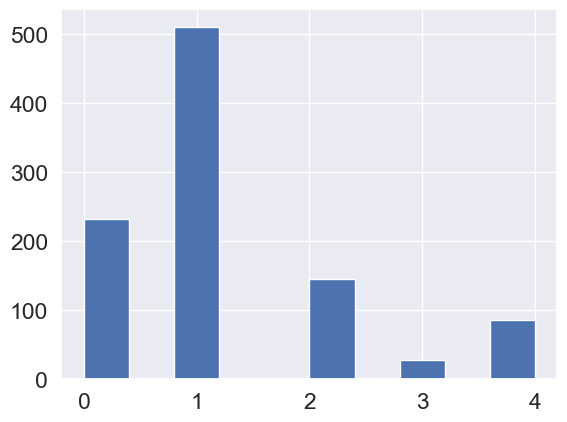

In [350]:
plt.hist(df[target_column])

### Data preprocessing

Remove columns with > 60% of missing data: 

In [351]:
def get_columns_with_high_percentage_missing_values(X, percentage=0.6):
    missing_percentage = X.isnull().mean()

    columns_to_drop = missing_percentage[missing_percentage > percentage].index
    return columns_to_drop

columns_to_drop = get_columns_with_high_percentage_missing_values(df)
print(f'Dropped columns: {list(columns_to_drop)}')
df.drop(columns=columns_to_drop, inplace=True)

Dropped columns: ['birth weight', 'birth length', 'week of gestation']


### Attribute groups

In [352]:
categorical_attributes = [
    'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'Hypertension', 'WC>88', 'WHR>0,85 (WHO)', 'WHR>0,8 (NIDDK)', 'WHTR>0,5', 
    'overweight/obesity 0-normal/low, 1-overweight, 2-obesity', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'hyperandrogenism', 'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'chronic thyroiditis',
    'follicules >12', 'hyperlipidemia', 'elevated LDL and TG', 'CHOL>200', 'HDL<50', 'LDL>135', 'TG>150', 'Impaired Fasting Glucose ', 'Impaired Glucose Tolerance', 
    'month of birth', 'quarter of the year',
    ]

continuous_attributes = list(df.columns.drop(categorical_attributes))

# parametry związane z układem krążenia i ryzykiem jego chorób
circulatory_system_attributes = [
    'proBNP', 'systolic BP (ciśnienie skurczowe)', 'diastolic BP (ciśnienie rozskurczowe)', 'Hypertension', 'hyperlipidemia', 'elevated LDL and TG',
    'CHOL mg/dl ', 'CHOL mmol/l', 'CHOL>200', ' HDL mg/dl', 'HDL mmol/l', 'HDL<50', 'LDL mg/dl', 'LDL mmol/l', 'LDL>135', 'TG', 'TG mmol/l', 'TG>150',
    'Atherogenic index (AI) (LDL-C/HDL-C) ', 'coronary risk index (CRI) (TG/HDL-C)', 'VAI - Visceral adiposity index', 'BAI - Body adiposity index',
    'LAP INDEX - Lipid accumulation product index', 'TyG Index - Trigliceride-glucose index', 'AIP -Atherogenic index of plasma',
    ]
# hormony płciowe plus morfologia jajnika
sex_hormones_attributes = [
    'AMH (ng/ml) *7,14=pmol/l', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'hyperandrogenism',
    'Vole of the Right Ovary', 'Volume of the  Left Ovary', 'ovaries volume - total', 'follicules >12', 'FSH mlU/ml', 'LH', 'LH/FSH', 'DHEA-S ug/dl', 'testosterone nmol/l',
    'T (ng/ml)', 'T/SHBG', 'E(pg/ml)/T(ng/ml)/', 'Estradiol pg/ml', 'SHBG nmol/l', 'FTI (free testosterone index)', 'Androstendione ng/ml', '17-OH-progesterone ng/ml',
    'Dihydrotestosterone pg/ml (N<368)', 'Testosterone/DHT', 'T/A (testosterone/androstendione)',
    ]
# gospodarka węglowodanowa (włączając oporność i wrazliwość na insulinę)
carbohydrate_metabolism_attributes = [
    'glucose 0 mg/dl', 'glucose  120 mg/dl', 'insulin 0 uU/ml', 'Insulin 120 uU/ml', 'HOMA', 'Matsuda', 'QUICKI (N<0,357)', 'Impaired Fasting Glucose ',
    'Impaired Glucose Tolerance',
    ]
# parametry antropometryczne
anthropometric_attributes = [
    'weight', 'height (cm)', 'BMI', 'Waist Circumference (WC)', 'WC>88', 'Hip Circumference (HC)', 'WHR (Waist/Hip ratio)', 'WHR>0,85 (WHO)',
    'WHR>0,8 (NIDDK)', 'WHTR (Waist/Height Ratio)', 'WHTR>0,5', 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
    ]
# parametry tarczycowe
thyroid_attributes = [
    'hypothyroidism', 'Volume of the thyroid  Right Lobe', 'Volume of the thyroid  Left Lobe', 'thyroid volume', 'nodules 0-lack, 1-RL,  2-LL, 3-both',
    'chronic thyroiditis', 'TSH mIU/L', 'FT3 pmol/l', 'FT4 pmol/l', 'Anty-TPO IU/ml', 'Anty-TG IU/ml',
    ]
# parametry zapalne
inflammatory_attributes = [
    'WBC x10^3/ul', 'neutrophil x10^3/ul', 'lymphocytes x10^3/ul', 'monocytes x10^3/ul', 'eosinocytes x10^3/ul', 'basophils x10^3/ul', '% neutrophil ', '% lymphocytes ',
    '% monocytes', '%eosinocytes ', '%basophils ', 'RBC x10^6ul', 'Hemoglobin [g/dl]', 'hematocrit [%]', 'HTC/Hb', 'MCV fl', 'MCH pg', 'MCHC g/dl', 'RDW-CV %', 'NRBC x10^3/ul',
    'PLT x10^3/ul', 'PDW fl', 'MPV fl', 'P-LCR %', 'PLT/WBC', 'MPV/PLT', 'PLR', 'limf/mono', 'NLR (stosunek neutrofili do limfocytów)',
    'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'CRP mg/l',
    ]
#  gospodarka żelazowa
iron_attributes = ['UIBC ug/dl', 'ferrum ug/dl', 'TIBC', 'TSAT', 'ferritin ng/ml']
# gospodarka wapniowo-fosforanowa
calcium_attributes = ['calcium mg/dl', 'phosphorus mg/dl', 'Parathormone pg/ml']

attribute_groups = [
    circulatory_system_attributes, sex_hormones_attributes, carbohydrate_metabolism_attributes, anthropometric_attributes,
    thyroid_attributes, inflammatory_attributes, iron_attributes, calcium_attributes]

In [353]:
df[categorical_attributes] = df[categorical_attributes].astype('Int8')
df[continuous_attributes] = df[continuous_attributes].astype('Float64')

In [354]:
continuous_attributes

['IGF-1 ng/ml (N: 100-311)',
 'proBNP',
 'AMH (ng/ml) *7,14=pmol/l',
 'weight',
 'height (cm)',
 'BMI',
 'systolic BP (ciśnienie skurczowe)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'Waist Circumference (WC)',
 'Hip Circumference (HC)',
 'WHR (Waist/Hip ratio)',
 'WHTR (Waist/Height Ratio)',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'Volume of the thyroid  Right Lobe',
 'Volume of the thyroid  Left Lobe',
 'thyroid volume',
 'Vole of the Right Ovary',
 'Volume of the  Left Ovary',
 'ovaries volume - total',
 'WBC x10^3/ul',
 'neutrophil x10^3/ul',
 'lymphocytes x10^3/ul',
 'monocytes x10^3/ul',
 'eosinocytes x10^3/ul',
 'basophils x10^3/ul',
 '% neutrophil ',
 '% lymphocytes ',
 '% monocytes',
 '%eosinocytes ',
 '%basophils ',
 'RBC x10^6ul',
 'Hemoglobin [g/dl]',
 'hematocrit [%]',
 'HTC/Hb',
 'MCV fl',
 'MCH pg',
 'MCHC g/dl',
 'RDW-CV %',
 'NRBC x10^3/ul',
 'PLT x10^3/ul',
 'PDW fl',
 'MPV fl',
 'P-LCR %',
 'PLT/WBC',
 'MPV/PLT',
 'PLR',
 'limf/mono',
 'NLR 

## Train test split

In [355]:
igf_df = df.dropna(subset=[igf])

X, y = igf_df.drop(columns=[igf]), igf_df[igf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Scaling

In [356]:
X_train.head()

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
765,2,17.08,4.822129,72.0,170.0,24.913495,122.0,74.0,0,71.0,0,90.0,0.788889,0,0,0.417647,0,0,1,<NA>,<NA>,<NA>,0,1,8.0,1,0,13.2,8.55,21.75,0,1,<NA>,<NA>,<NA>,<NA>,0,0,5.62,3.49,1.57,0.33,0.21,0.02,62.1,27.9,5.9,3.7,0.4,4.5,13.3,39.0,2.932331,86.7,29.6,34.1,11.7,0.0,208.0,12.7,10.7,31.0,37.010676,0.051442,132.484076,4.757576,2.22293,0.279359,0.037367,143.0,4.17,9.66,3.54,0.73,0.7,8.0,12.0,0.35,175.0,4.5255,0,77.0,1.99122,0,89.4,2.311884,0,46.0,0.51934,0,1.161039,0.597403,0.415334,34.941176,6.75142,4.158639,-0.223733,<NA>,96.0,343.0,28.0,36.0,89.0,92.0,13.26,40.42,2.913926,4.77,0.325528,0,0,2.77,4.85,15.23,8.0,10.0,6.0,8.3,1.383333,311.0,335.0,0.8,0.230548,0.013378,147.474999,32.45,215.0,58.0,34.0,59.8,1.27,15.76,4.6,9.0,3.2,1.4,205.0,0.003902,0.25,11,4,22.0
657,1,44.12,34.42,71.0,170.0,24.567474,126.0,86.0,0,80.0,0,86.0,0.930233,1,1,0.470588,0,0,1,0,1,1,0,1,10.0,1,1,6.375,5.64,12.015,0,1,18.7,22.59,41.29,1,0,0,6.37,3.59,1.68,0.47,0.56,0.07,53.6,26.4,7.4,8.8,1.1,4.28,13.3,37.8,2.842105,88.3,31.1,35.2,12.4,0.0,221.0,13.2,10.9,32.4,34.693878,0.049321,131.547619,3.574468,2.136905,0.263736,0.087912,144.0,4.28,9.5,2.21,0.95,0.6,8.0,15.0,0.7,184.0,4.75824,0,58.0,1.49988,0,99.7,2.578242,0,132.0,1.49028,0,1.718966,2.275862,1.796868,32.588235,32.78616,4.662727,0.357146,135.0,191.0,326.0,58.0,26.0,85.0,73.0,6.59,17.21,1.383086,13.78,0.363861,0,0,3.7,5.01,14.59,15.0,251.0,4.9,14.8,3.020408,311.0,193.0,2.7,0.778098,0.057325,100.24444

In [357]:
def get_continuous_attributes_except(attribute):
    remaining_attributes = continuous_attributes.copy()
    remaining_attributes.remove(attribute)
    return remaining_attributes


class Scaler:
    def __init__(self, scaling_method, attributes_to_scale):
        self.scaling_method = scaling_method
        self.attributes_to_scale = attributes_to_scale
        self.scaler = None

    # def fit(self, X):
    #     self.scaler = ColumnTransformer(
    #         transformers=[
    #             ('scaler', self.scaling_method, self.attributes_to_scale)
    #         ],
    #         # so that the categorical columns remain unchanged
    #         remainder='passthrough',
    #         # so it doesn't rename the columns
    #         verbose_feature_names_out=False,
    #         )
    #     self.scaler.set_output(transform='pandas')
    #     self.scaler.fit(X)


    def fit_transform(self, X):
        self.scaler = ColumnTransformer(
            transformers=[
                ('scaler', self.scaling_method, self.attributes_to_scale)
            ],
            # so that the categorical columns remain unchanged
            remainder='passthrough',
            # so it doesn't rename the columns
            verbose_feature_names_out=False,
            )
        self.scaler.set_output(transform='pandas')
        return self.scaler.fit_transform(X)
    
    def transform(self, X):
        if not self.scaler:
            return RuntimeError('Call fit_tranform() method first')
        return self.scaler.transform(X)


## Tests for scaling methods

In [358]:
def round_numeric_values(arr, decimals=5):
    # Create a mask to identify non-null numeric values
    mask = np.isnan(arr)
    # Round only the numeric values using the mask
    arr_rounded = np.where(mask, np.round(arr, decimals), arr)
    
    return arr_rounded


def test_scaler__scales_properly(scaling_method=RobustScaler()):
    column_1 = 'thyroid volume'
    column_2 = ' HDL mg/dl'
    column_3 = 'prolactin'
    columns_to_test = [column_1, column_2, column_3]


    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        # expected
        scaler = scaling_method
        expected_column = scaler.fit_transform(df_tmp[[column]])

        # result
        true_scaler = Scaler(scaling_method, attributes_to_scale=get_continuous_attributes_except(igf))
        scaled_df = true_scaler.fit_transform(df_tmp)
        result_column = scaled_df[[column]].astype('float64').values

        expected_column_rounded = round_numeric_values(expected_column)
        result_column_rounded = round_numeric_values(result_column)

        # Create masks to exclude NaN values
        expected_mask = ~np.isnan(expected_column_rounded)
        result_mask = ~np.isnan(result_column_rounded)

        try:
            # Compare only non-NaN values
            assert np.array_equal(expected_column_rounded[expected_mask], result_column_rounded[result_mask])
            print("===PASSED===", column)
        except AssertionError:
            diff_indices = np.where(expected_column_rounded != result_column_rounded)[0]
            print("---FAILED---", column)
            print(f"Arrays differ in column {column} at indices: {diff_indices}")
    

def test_scaler__categorical_variables_remain_unchanged(scaling_method=RobustScaler()):
    column_1 = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'
    column_2 = 'LDL>135'
    column_3 = 'Impaired Glucose Tolerance'

    columns_to_test = [column_1, column_2, column_3]

    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        scaler = Scaler(scaling_method, attributes_to_scale=get_continuous_attributes_except(igf))
        scaled_df = scaler.fit_transform(df_tmp)
        result_column = scaled_df[[column]].astype("Int8")

        try:
            assert result_column.equals(df_tmp[[column]])
            print("===PASSED===", column)
        except AssertionError:
            print("---FAILED---", column)


test_scaler__scales_properly(scaling_method=RobustScaler())
test_scaler__scales_properly(scaling_method=PowerTransformer())
test_scaler__categorical_variables_remain_unchanged(scaling_method=RobustScaler())
test_scaler__categorical_variables_remain_unchanged(scaling_method=PowerTransformer())

===PASSED===

 thyroid volume
===PASSED===  HDL mg/dl
===PASSED=== prolactin
===PASSED=== thyroid volume
===PASSED===  HDL mg/dl
===PASSED=== prolactin
===PASSED=== PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro
===PASSED=== LDL>135
===PASSED=== Impaired Glucose Tolerance
===PASSED=== PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro
===PASSED=== LDL>135
===PASSED=== Impaired Glucose Tolerance


In [359]:
power_transformer_scaler = Scaler(PowerTransformer(), get_continuous_attributes_except(igf))
X_power_transformer = power_transformer_scaler.fit_transform(X_train)
X_power_transformer.head(5)

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-1.201959,-0.238295,0.388605,0.480548,0.218538,0.139139,0.025613,-0.585074,0.242228,-1.437601,-0.738427,0.434540,2.135583,1.613519,1.918527,NaN,NaN,NaN,-0.170029,0.124300,-0.630353,-0.950588,0.834528,-1.232432,0.583163,-0.537374,-0.948803,0.896019,-0.927444,0.033663,0.037037,0.002723,-0.106264,-0.085337,-0.037655,0.193406,-1.569725,-0.192847,-0.918639,0.153509,0.090547,0.140221,-0.561667,0.861168,-0.149897,0.319726,0.577379,-0.553325,0.975649,0.516055,-0.285259,0.199164,-0.160066,-0.024208,-0.259251,-1.734871,-1.394950,-0.414113,0.047795,0.048797,0.759850,0.764710,-0.110293,-0.110962,-1.182505,-1.200041,-0.522854,-1.223770,-1.338021,0.063745,-0.823343,-1.058225,-1.218069,NaN,0.195826,0.004263,0.109278,0.066227,0.178457,-0.232393,0.633744,-0.093519,0.630083,-0.446263,-0.598649,0.582213,-0.163476,-0.320397,-1.060252,-0.836272,0.234598,0.044501,-0.093056,-0.083425,0.280563,-1.086282,-1.107792,-0.897227,0.311334,-0.545987,-1.230920,-1.860876,-0.380020,0.115579,-0.937128,-0.459537,-1.480831,-1.651338,-0.079356,-1.081283,-1.256607,0.026700,-1.286192,-0.587502,2,0,0,0,0,0,0,1,<NA>,<NA>,<NA>,0,1,1,0,0,1,<NA>,0,0,0,0,0,0,0,0,11,4
657,0.229864,3.174402,0.331362,0.480548,0.158251,0.415999,1.097873,0.234766,-0.102514,0.576581,0.097572,0.672161,0.545595,0.832614,0.713049,1.525365,2.043600,1.958551,0.240178,0.192557,-0.407018,0.183753,2.022928,1.394953,-0.320481,-0.725705,-0.032152,2.228741,1.223567,-0.556054,0.037037,-0.414514,

In [360]:
def plot_continuous_attribute_distributions(X, columns):
    n_rows = 29
    n_cols = 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 120))

    for i, col in enumerate(columns):
        ax = axes[int(i/n_cols)][i%n_cols]
        sns.histplot(X[col], kde=True, ax=ax)
        ax.set_title("\n".join(wrap(col, 40)) + '\n')
        ax.set_xlabel('')

    fig.tight_layout()
    plt.show()

Power Transformer

In [361]:
columns_to_scale = get_continuous_attributes_except(igf)
power_transformer_scaler = Scaler(PowerTransformer(), columns_to_scale)
X_power_transformer = power_transformer_scaler.fit_transform(X_train)
# X_power_transformer.head(5)

# plot_continuous_attribute_distributions(X_power_transformer, columns_to_scale)

Robust Scaler

In [362]:
columns_to_scale = get_continuous_attributes_except(igf)
robust_scaler = Scaler(RobustScaler(), columns_to_scale)
X_train_robust_scaler = robust_scaler.fit_transform(X_train)
# X_robust_scaler.head(5)
X_test_robust_scaler = robust_scaler.transform(X_test)

# plot_continuous_attribute_distributions(X_robust_scaler, columns_to_scale)
# plot_continuous_attribute_distributions(X_test_robust_scaler, columns_to_scale)

## Handle missing data

- < 50% missing --> remove columns
- resztę -> zastapić mediana

In [363]:
imputer = SimpleImputer(strategy='median')
imputer.set_output(transform='pandas')

X_train_imputed = imputer.fit_transform(X_train_robust_scaler)
X_test_imputed = imputer.transform(X_test_robust_scaler)


X_train_imputed[categorical_attributes] = X_train_imputed[categorical_attributes].astype('Int8')
X_test_imputed[categorical_attributes] = X_test_imputed[categorical_attributes].astype('Int8')

In [364]:
X_train_imputed.head()

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,2,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,11,4
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.087233,0.4,0.429054,0.849857,0.635211,1.377593,2.259394e+00,1.937916e+00,0.157158,0.107246,-0.277027,0.166667,3.666667,1.5,-0.241715,-0.509091,-0.044944,3.884058,1.25,-0.44,0.076923,-0.303448,-0.812127,0.250000,0.666667,0.833333,-0.1818

## One-hot encoding

One-hot encoding for PCO, overweight, nodules

In [365]:
class OneHotEncoder:
    def __init__(self, columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=False):
        self.columns_for_one_hot_encoding = columns_for_one_hot_encoding
        self.new_column_names_map = new_column_names_map
        self.advanced_encoding = advanced_encoding

    def fit_transform(self, X):
        for col, prefix in self.columns_for_one_hot_encoding.items():
            X = pd.get_dummies(X, columns=[col], prefix=prefix, dtype=np.int8)

        X = X.rename(columns=self.new_column_names_map)

        # more advanced encoding for nodules:
        # if nodules_both_sides = 1, then nodules_right = 1 and nodules_left = 1
        if self.advanced_encoding:
            X['nodules_right'] = X['nodules_right'] | X['nodules_both_sides']
            X['nodules_left'] = X['nodules_left'] | X['nodules_both_sides']
        # 
        return X
    
    # def transform(self, X):
    #     for col, prefix in self.columns_for_one_hot_encoding.items():
    #         X = pd.get_dummies(X, columns=[col], prefix=prefix, dtype=np.int8)

    #     X = X.rename(columns=self.new_column_names_map)

    #     # more advanced encoding for nodules:
    #     # if nodules_both_sides = 1, then nodules_right = 1 and nodules_left = 1
    #     if self.advanced_encoding:
    #         X['nodules_right'] = X['nodules_right'] | X['nodules_both_sides']
    #         X['nodules_left'] = X['nodules_left'] | X['nodules_both_sides']
    #     # 
    #     return X
    
    def update_categorical_attributes_list(self, categorical_attributes):
        #  remove no longer existing columns
        for old_col in self.columns_for_one_hot_encoding.keys():
            if old_col in categorical_attributes:
                categorical_attributes.remove(old_col)

        # add new columns
        for new_col in self.new_column_names_map.values():
            if new_col not in categorical_attributes:
                categorical_attributes.append(new_col)

        return categorical_attributes
    
    def get_name(self):
        if self.advanced_encoding:
            return "advanced"
        else:
            return "basic"

In [366]:
columns_for_one_hot_encoding = {'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro': 'PCO',
                             'overweight/obesity 0-normal/low, 1-overweight, 2-obesity': 'overweight',
                             'nodules 0-lack, 1-RL,  2-LL, 3-both': 'nodules',
                             'quarter of the year': 'birth_quarter',
                             'month of birth': 'birth_month',
                             }

new_column_names_map = {
    'PCO_0': '0_healthy_control',
    'PCO_1': '1_PCOS',
    'PCO_2': '2_FHA',
    'PCO_3': '3_POF',
    'PCO_4': '4_High_Andro',
    'overweight_0': '0_normal_weight',
    'overweight_1': '1_overweight',
    'overweight_2': '2_obesity',
    'nodules_0': 'no_nodules',
    'nodules_1': 'nodules_right',
    'nodules_2': 'nodules_left',
    'nodules_3': 'nodules_both_sides',
    }

one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)

X_train_encoded = one_hot_encoder.fit_transform(X_train_imputed)
X_test_encoded = one_hot_encoder.fit_transform(X_test_imputed)

# categorical_attributes = one_hot_encoder.update_categorical_attributes_list(categorical_attributes)

In [367]:
X_train_imputed.head()

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,2,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,11,4
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.087233,0.4,0.429054,0.849857,0.635211,1.377593,2.259394e+00,1.937916e+00,0.157158,0.107246,-0.277027,0.166667,3.666667,1.5,-0.241715,-0.509091,-0.044944,3.884058,1.25,-0.44,0.076923,-0.303448,-0.812127,0.250000,0.666667,0.833333,-0.1818

In [344]:
X_train_encoded.head(5)

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,0_healthy_control,1_PCOS,2_FHA,3_POF,4_High_Andro,0_normal_weight,1_overweight,2_obesity,no_nodules,nodules_right,nodules_left,nodules_both_sides,birth_quarter_1,birth_quarter_2,birth_quarter_3,birth_quarter_4,birth_month_1,birth_month_2,birth_month_3,birth_month_4,birth_month_5,birth_month_6,birth_month_7,birth_month_8,birth_month_9,birth_month_10,birth_month_11,birth_month_12
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.

### Baseline model

In [390]:

from sklearn.linear_model import LinearRegression


baseline_model_scores_df = pd.DataFrame(columns=['target_attribute', 'model', 'scaling_method', 'one_hot_enroder', 'train_mse', 'test_mse'])

for target_attribute in [igf, prolactin, vit_d]:
    #  train test split

    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])

    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for scaling_method in [RobustScaler(), PowerTransformer()]:
        # scaling
        attributes_to_scale = get_continuous_attributes_except(target_attribute)

        scaler = Scaler(scaling_method, attributes_to_scale)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # for missing_values_imputer in [SimpleImputer(), KNNImputer()]: # this in the tuned loop

        # missing data imputation
        # continuous data
        imputer_continuous = SimpleImputer(strategy='median') # make a distinction: for continuous: median and for categorical: mode
        imputer_continuous.set_output(transform='pandas')

        X_train_continuous_imputed = imputer_continuous.fit_transform(X_train_scaled[attributes_to_scale])
        X_test_continuous_imputed = imputer_continuous.transform(X_test_scaled[attributes_to_scale])

        #  categorical
        imputer_categorical = SimpleImputer(strategy='most_frequent') # make a distinction: for continuous: median and for categorical: mode
        imputer_categorical.set_output(transform='pandas')

        X_train_categorical_imputed = imputer_categorical.fit_transform(X_train_scaled[categorical_attributes]).astype('Int8')
        X_test_categorical_imputed = imputer_categorical.transform(X_test_scaled[categorical_attributes]).astype('Int8')

        # X_train_imputed[categorical_attributes] = X_train_imputed[categorical_attributes].astype('Int8')
        # X_test_imputed[categorical_attributes] = X_test_imputed[categorical_attributes].astype('Int8')

        X_train_imputed = pd.concat([X_train_continuous_imputed, X_train_categorical_imputed], axis=1)
        X_test_imputed = pd.concat([X_test_continuous_imputed, X_test_categorical_imputed], axis=1)

        # one hot encoding

        for one_hot_encoder in [OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True), OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map)]:

            X_train_encoded = one_hot_encoder.fit_transform(X_train_imputed)
            X_test_encoded = one_hot_encoder.fit_transform(X_test_imputed)

            # prediction
            # TODO: change into cross validation
            for model in [DecisionTreeRegressor(max_depth=5, random_state=42), LinearRegression()]:
                # model = DecisionTreeRegressor(max_depth=5, random_state=42)
                model.fit(X_train_encoded, y_train)
                y_train_pred = model.predict(X_train_encoded)
                y_test_pred = model.predict(X_test_encoded)

                train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
                test_mse = round(mean_squared_error(y_test, y_test_pred), 3)

                baseline_model_scores_df.loc[len(baseline_model_scores_df)] = [target_attribute, str(model), str(scaling_method), one_hot_encoder.get_name(), train_mse, test_mse]
                
                # print()
                # print(target_attribute, str(scaling_method), one_hot_encoder.get_name(), train_mse, test_mse)
                # feature_importances = [*zip(model.feature_importances_, X_train_encoded.columns)]
                # feature_importances_sorted = sorted(feature_importances, key=lambda x:-x[0])
                # print(feature_importances_sorted)

baseline_model_scores_df




,target_attribute,model,scaling_method,one_hot_enroder,train_mse,test_mse
0,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",RobustScaler(),advanced,4333.973,7.601252e+03
1,IGF-1 ng/ml (N: 100-311),LinearRegression(),RobustScaler(),advanced,3415.560,7.832649e+03
2,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",RobustScaler(),basic,4333.973,7.521962e+03
3,IGF-1 ng/ml (N: 100-311),LinearRegression(),RobustScaler(),basic,3415.560,7.832649e+03
4,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",PowerTransformer(),advanced,4333.973,7.601252e+03
5,IGF-1 ng/ml (N: 100-311),LinearRegression(),PowerTransformer(),advanced,3804.244,7.336521e+03
6,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",PowerTransformer(),basic,4333.973,7.521962e+03
7,IGF-1 ng/ml (N: 100-311),LinearRegression(),PowerTransformer(),basic,3630.848,7.199040e+03
8,prolactin,"DecisionTreeRegressor(max_depth=5, random_stat...",RobustScaler(),advanced,31337.151,1.792160e+05
9,prolactin,LinearRegression(),RobustScaler(),advanced,48146.118,1.160917e+05


In [267]:
# model = DecisionTreeRegressor(random_state=42)

# # Fit the model on the training data
# model.fit(X_train_preprocessed, y_train)

# # Predict on the testing data
# y_pred = model.predict(X_test_preprocessed)

# # Calculate Mean Squared Error (MSE) as evaluation metric
# mse = mean_squared_error(y_test, y_pred)

# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"R2 : {r2}")

### Feature selection

In [28]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_preprocessed, y_train)
importances = np.abs(lasso.coef_)

In [29]:

selector = SelectFromModel(model, threshold=0.1)
selector.fit(X_train_preprocessed, y_train)
selected_features = X_train_preprocessed.columns[selector.get_support()]
selected_features

Index(['age'], dtype='object')

In [30]:

result = permutation_importance(model, X_test_preprocessed, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# # Associate each importance value with its corresponding feature name
feature_importances = dict(zip(X_test_preprocessed.columns, importances))

# Print the columns together with their importances
for feature, importance in feature_importances.items():
    if importance != 0:
        print(f"{feature}: {importance}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- birth_month_-0.2
- birth_month_-0.4
- birth_month_-0.6
- birth_month_-0.8
- birth_month_-1.0
- ...
Feature names seen at fit time, yet now missing:
- birth_month_-0.16666666666666666
- birth_month_-0.3333333333333333
- birth_month_-0.5
- birth_month_-0.6666666666666666
- birth_month_-0.8333333333333334
- ...


In [31]:
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train_preprocessed, y_train)
importances = rfe.ranking_

feature_importances = dict(zip(X_test_preprocessed.columns, importances))

sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1])

# Print the columns together with their importances
for feature, importance in sorted_feature_importances:
    if importance != 0:
        print(f"{feature}: {importance}")

WHR (Waist/Hip ratio): 1
% lymphocytes : 1
P-LCR %: 1
HOMA: 1
age: 1
ALT U/l: 2
hematocrit [%]: 3
PLT x10^3/ul: 4
Estradiol pg/ml: 5
LDL mmol/l: 6
MCH pg: 7
glucose  120 mg/dl: 8
Dihydrotestosterone pg/ml (N<368): 9
MPV fl: 10
CRP mg/l: 11
LH/FSH: 12
FT4 pmol/l: 13
FT3 pmol/l: 14
VAI - Visceral adiposity index: 15
ovaries volume - total: 16
neutrophil x10^3/ul: 17
RDW-CV %: 18
Matsuda: 19
TIBC: 20
Anty-TG IU/ml: 21
cortisol nmol/l  8:00: 22
TSH mIU/L: 23
T/SHBG: 24
thyroid volume: 25
CHOL mg/dl : 26
overweight_1.0: 27
FG score (Ferriman-Gallway score - stopień androgenizacji): 28
Hemoglobin [g/dl]: 29
lymphocytes x10^3/ul: 30
Anty-TPO IU/ml: 31
AST U/l: 32
Vole of the Right Ovary: 33
DHEA-S ug/dl: 34
nodules_0.0: 35
T (ng/ml): 36
potassium mmol/l: 37
SHBG nmol/l: 38
Atherogenic index (AI) (LDL-C/HDL-C) : 39
Volume of the thyroid  Left Lobe: 40
Parathormone pg/ml: 41
BAI - Body adiposity index: 42
% neutrophil : 43
QUICKI (N<0,357): 44
glucose 0 mg/dl: 45
birth_month_0.6: 46
Testosteron

In [32]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_preprocessed.shape[1]):

    print(f"{f + 1}. Feature '{X_train_preprocessed.columns[indices[f]]}' ({importances[indices[f]]})")

Feature ranking:
1. Feature 'age' (0.11558109256072505)
2. Feature '% lymphocytes ' (0.037067424059781806)
3. Feature '17-OH-progesterone ng/ml' (0.02265471763561137)
4. Feature 'insulin 0 uU/ml' (0.02005921061817757)
5. Feature 'ALT U/l' (0.020031333707779757)
6. Feature 'TIBC' (0.018341271049474084)
7. Feature 'P-LCR %' (0.0180263764801652)
8. Feature 'DHEA-S ug/dl' (0.017381523781329275)
9. Feature 'E(pg/ml)/T(ng/ml)/' (0.013925019525298177)
10. Feature 'Dihydrotestosterone pg/ml (N<368)' (0.01381382592287395)
11. Feature 'FT3 pmol/l' (0.013211499351731826)
12. Feature 'MPV fl' (0.013196172022832464)
13. Feature 'QUICKI (N<0,357)' (0.012496564375672798)
14. Feature 'ferritin ng/ml' (0.011887067391901414)
15. Feature 'Hemoglobin [g/dl]' (0.011773180214576847)
16. Feature 'WHTR (Waist/Height Ratio)' (0.010941850797454569)
17. Feature 'neutrophil x10^3/ul' (0.01090754824336664)
18. Feature 'phosphorus mg/dl' (0.010880616821887323)
19. Feature 'SHBG nmol/l' (0.010875881110953065)
20. Fe

## Training pipeline

### Scaler

### Imputer

In [33]:
class MissingDataImputer:
    def __init__(self, 
                columns_to_drop_rows_if_missing_value=[],
                columns_to_impute_with_median=[],
                columns_to_impute_with_knn=[],
                columns_to_drop=[]):
        self.columns_to_drop_rows_if_missing_value = columns_to_drop_rows_if_missing_value
        self.columns_to_impute_with_median = columns_to_impute_with_median
        self.columns_to_impute_with_knn = columns_to_impute_with_knn
        self.columns_to_drop = columns_to_drop

    def impute(self, X, y):
        X, y = X.copy(), y.copy()

        # Drop rows for which the values in specified columns are missing
        if self.columns_to_drop_rows_if_missing_value:
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
            X = X.dropna(subset=self.columns_to_drop_rows_if_missing_value)
            y = y.loc[X.index] # leave only the relevant rows in y

        # Impute specified columns with median
        if self.columns_to_impute_with_median:
            #  TODO: fit transform only on the training set and only transform on the test set
            median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            X[self.columns_to_impute_with_median] = median_imputer.fit_transform(X[self.columns_to_impute_with_median])

        # Impute specified columns with knn
        if self.columns_to_impute_with_knn:
            #  TODO: fit transform only on the training set and only transform on the test set
            knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
            X[self.columns_to_impute_with_knn] = knn_imputer.fit_transform(X[self.columns_to_impute_with_knn])

        # Drop specified columns
        if self.columns_to_drop:
            X = X.drop(columns=self.columns_to_drop)
        
        return X, y